# HW03: Data Modeling 

This is Assignment 02 for the course "Introduction to Data Science" at the Faculty of Information Technology, University of Science, Vietnam National University, Ho Chi Minh City.

---

(Latest update: 26/10/2024)

Student Name: Võ Nguyễn Phương Quỳnh

Student ID: 22127360

---

## **How to Complete and Submit the Assignment**

&#9889; **Note**: You should follow the instructions below. If anything is unclear, you need to contact the teaching assistant or instructor immediately for timely support.

**How to Do the Assignment**

You will work directly on this notebook file. First, fill in your full name and student ID (MSSV) in the header section of the file above. In the file, complete the tasks in sections marked:
```python
# YOUR CODE HERE
raise NotImplementedError()
```
Or for optional code sections:
```python
# YOUR CODE HERE (OPTION)
```
For markdown cells, complete the answer in the section marked:
```markdown
YOUR ANSWER HERE
```

**How to Submit the Assignment**

Before submitting, select `Kernel` -> `Restart Kernel & Run All Cells` if you are using a local environment, or `Runtime -> Restart session` and run all if using Google Colab, to ensure everything works as expected.

Next, create a submission folder with the following structure:
- Folder named `MSSV` (for example, if your student ID is `1234567`, name the folder `1234567`)
    - File `HW02.ipynb` (no need to submit other files)

Finally, compress this `MSSV` folder in `.zip` format (not `.rar` or any other format) and submit it via the link on Moodle.\
<font color=red>Please make sure to strictly follow this submission guideline.</font>

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
%pip install imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


---

## Data collecting

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). You can download these data from this [link](https://archive.ics.uci.edu/dataset/186/wine+quality).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

---

## Data Preparation

### Read raw data from file

In [2]:
# YOUR CODE HERE
raw_white = pd.read_csv('data/winequality-white.csv', delimiter=';')
raw_red = pd.read_csv('data/winequality-red.csv', delimiter=';')

Combine the two dataframes and add a `colors` column to distinguish between red and white wines. Named the dataframe as `raw_df`.

In [3]:
raw_df = pd.concat([raw_white, raw_red], ignore_index=True)

Next, we calculate the number of rows with duplicate indexes and store it in the variable `red_num_duplicated_rows` and `white_num_duplicated_rows`. In a group of lines with the same index, the first line is not counted as repeated.

In [4]:
raw_df.drop_duplicates(keep=False, inplace=True)

Next, you calculate the data type (dtype) of each column in DataFrame `raw_df` and save the result into Series `dtypes` (This Series has the index as the column name).

In [5]:
dtypes = raw_df.dtypes
dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

For columns with numeric data types, we will calculate:
- Percentage (from 0 to 100) of missing values
- The min
- The lower quartile (phân vị 25)
- The median (phân vị 50)
- The upper quartile (phân vị 75)
- The max

In [6]:
num_col_info_df = raw_df.select_dtypes(include='float64')

def missing_ratio(df):
    return (df.isnull().mean() * 100).round(1)

def min(df):
    return df.min().round(1)

def lower_quartile(df):
    return df.quantile(0.25).round(1)

def median(df):
    return df.median().round(1)

def upper_quartile(df):
    return df.quantile(0.75).round(1)

def max(df):
    return df.max().round(1)

num_col_info_df = num_col_info_df.agg([missing_ratio, min, lower_quartile, median, upper_quartile, max])
num_col_info_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,3.8,0.1,0.0,0.7,0.0,1.0,6.0,1.0,2.7,0.2,8.0
lower_quartile,6.4,0.2,0.2,1.7,0.0,16.0,72.0,1.0,3.1,0.4,9.6
median,6.9,0.3,0.3,2.6,0.0,27.0,114.0,1.0,3.2,0.5,10.4
upper_quartile,7.7,0.4,0.4,6.8,0.1,40.0,152.0,1.0,3.3,0.6,11.4
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9


We can see all the features have 0% of missing ratio => No need to drop any missing features and fill missing value.

Detect and handle outliers

In [7]:
def analyze_outliers(df, columns):
    outlier_info = {}

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

        outlier_info[column] = {
            'total_outliers': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'min': outliers.min() if len(outliers) > 0 else None,
            'max': outliers.max() if len(outliers) > 0 else None
        }
    
    return outlier_info

# Analyze outliers
df_numeric = raw_df.select_dtypes(include='float64')
outlier_info = analyze_outliers(df_numeric, df_numeric.columns)

print("Outlier Information:")
for column, info in outlier_info.items():
    print(f"\tOutliers in {column}:")
    print(f"\tTotal outliers: {info['total_outliers']} ({info['percentage']:.2f}%)")
    print(f"\tMin: {info['min']}")
    print(f"\tMax: {info['max']}")
    print()

Outlier Information:
	Outliers in fixed acidity:
	Total outliers: 253 (5.85%)
	Min: 3.8
	Max: 15.9

	Outliers in volatile acidity:
	Total outliers: 211 (4.88%)
	Min: 0.695
	Max: 1.58

	Outliers in citric acid:
	Total outliers: 113 (2.61%)
	Min: 0.65
	Max: 1.66

	Outliers in residual sugar:
	Total outliers: 157 (3.63%)
	Min: 14.5
	Max: 65.8

	Outliers in chlorides:
	Total outliers: 198 (4.58%)
	Min: 0.111
	Max: 0.611

	Outliers in free sulfur dioxide:
	Total outliers: 39 (0.90%)
	Min: 77.0
	Max: 289.0

	Outliers in total sulfur dioxide:
	Total outliers: 10 (0.23%)
	Min: 278.0
	Max: 440.0

	Outliers in density:
	Total outliers: 1 (0.02%)
	Min: 1.03898
	Max: 1.03898

	Outliers in pH:
	Total outliers: 54 (1.25%)
	Min: 2.72
	Max: 4.01

	Outliers in sulphates:
	Total outliers: 148 (3.42%)
	Min: 0.85
	Max: 2.0

	Outliers in alcohol:
	Total outliers: 2 (0.05%)
	Min: 14.2
	Max: 14.9



**Interquatile Range (IQR) Method**

***Steps:***
* Calculate the 1st Quartile ($Q1$) (25th percentile) and the 3rd Quartile ($Q3$) (75th percentile) of the data.
* Compute the IQR: $IQR = Q3 - Q1$
* Define the lower and upper bounds:
$$Lower Bound = Q1 - 1.5 * IQR$$
$$Upper Bound = Q3 - 1.5 * IQR$$
* Outliers are values that fall below the lower bound or above the upper bound.
* Replace the outliers with the nearest bound (capping) using clip():
    * Values below the lower bound are set to the lower bound.
    * Values above the upper bound are set to the upper bound.

***Pros:*** Simple and effective for many datasets. Not sensitive to extreme outliers, as it only considers the middle 50% of the data.

***Cons:*** Assumes a symmetric distribution and may not perform well for skewed data.

In [8]:
def handle_outliers(df):
    '''
    Handles outliers in specified columns of a DataFrame using the specified method.

    -------------
    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        columns_handle (list): List of column names to handle outliers for.
        method (str): The method to use for handling outliers. 
                    Options are 'iqr' (Interquartile Range) and 'percentile'. 
                    Default is 'iqr'.
                
    -------------
    Returns:
        pandas.DataFrame: A DataFrame with outliers handled in the specified columns.
    '''
    df_cleaned = df.copy()

    for column in df.columns:
        if df[column].dtype != 'float64':
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_cleaned[column] = df_cleaned[column].clip(lower_bound, upper_bound)

    return df_cleaned

df = handle_outliers(raw_df)

# Analyze outliers
df_numeric = df.select_dtypes(include='float64')
outlier_info = analyze_outliers(df_numeric, df_numeric.columns)

print("Outlier Information:")
for column, info in outlier_info.items():
    print(f"\tOutliers in {column}:")
    print(f"\tTotal outliers: {info['total_outliers']} ({info['percentage']:.2f}%)")
    print(f"\tMin: {info['min']}")
    print(f"\tMax: {info['max']}")
    print()

Outlier Information:
	Outliers in fixed acidity:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in volatile acidity:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in citric acid:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in residual sugar:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in chlorides:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in free sulfur dioxide:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in total sulfur dioxide:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in density:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in pH:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in sulphates:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None

	Outliers in alcohol:
	Total outliers: 0 (0.00%)
	Min: None
	Max: None



Look at the distribution of `quality`

In [9]:
df.sort_values(by='quality', ascending=True, inplace=True)

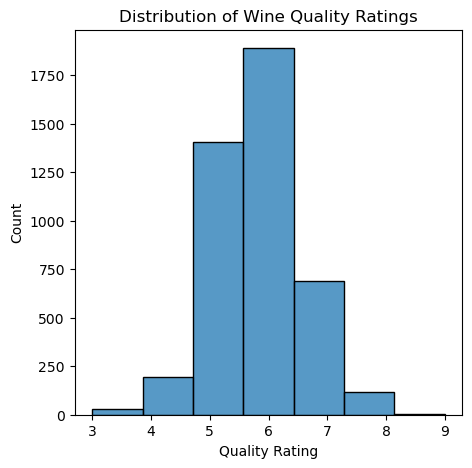

In [10]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='quality', bins=7)
plt.title('Distribution of Wine Quality Ratings')
plt.xlabel('Quality Rating')
plt.ylabel('Count')
plt.show()

Now we define the quality point into 3 classes:
- 3, 4: bad
- 5, 6: moderate
- 7, 8, 9: good

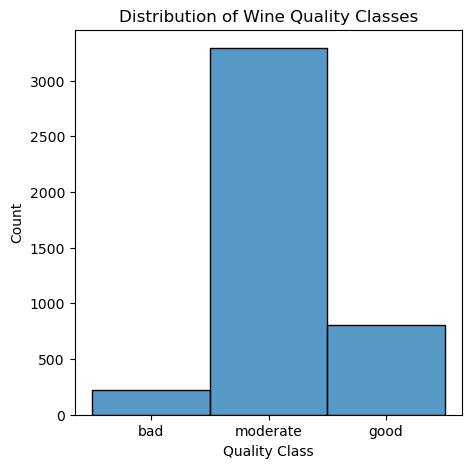

In [11]:
df['quality'] = pd.cut(
    df['quality'],
    bins=[2, 4, 6, 9],  # Define the boundaries for each category
    labels=['bad', 'moderate', 'good']  # Assign labels for each category
)
df['quality'] = df['quality'].astype(str)

plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='quality')
plt.title('Distribution of Wine Quality Classes')
plt.xlabel('Quality Class')
plt.ylabel('Count')
plt.show()

In [12]:
dtypes = df.dtypes
dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                  object
dtype: object

Splitting data into input features(`X`) and target variable (`y`). Here, we drop the 'quality' column from the dataset to use as the target variable. The remaining columns are treated as input features for model training

In [13]:
X = df.drop(columns=['quality'])
y = df['quality']

Standardize the features in X as they have different scales and units (can be seen in the below box plot)

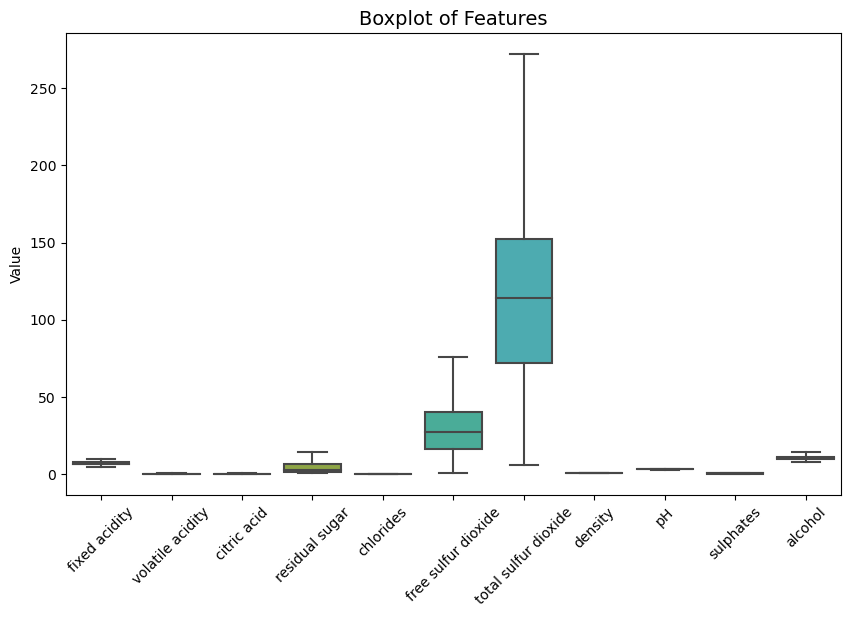

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title('Boxplot of Features', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.show()

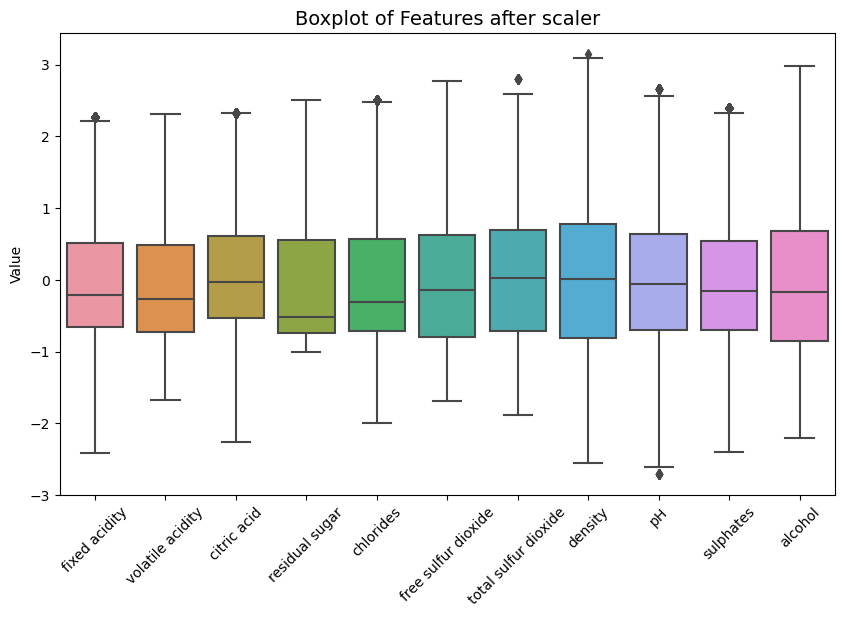

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(data=X_scaled)
plt.title('Boxplot of Features after scaler', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.show()

Splitting dataset into training, validation and testing sets:
* 60% training data
* 20% validation data
* 20% testing data

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=1/2, random_state=42)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_valid.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Data split completed:
Training set: 2595 samples
Validation set: 865 samples
Testing set: 865 samples


## Data Modeling

In this section, we're going to build some classification models to predict the wine quality. Three different machine learning models were implemented to compare performance:
* Random Forest Classifier
* Gradient Boosting Classifier
* AdaBoost Classifier

First, we define some fucntion to support the training process.

In [17]:
def evaluate_model(model, X_test, y_test, model_name, dataset='Test'):
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"\n--- {model_name} ---")
    print(f"{dataset} Accuracy: {test_accuracy:.4f}")
    
    # Visualize Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Visualize Classification Report
    class_report = classification_report(y_test, y_test_pred, output_dict=True)
    report_df = pd.DataFrame(class_report).transpose()
    plt.figure(figsize=(6, 4))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
    plt.title(f"Classification Report - {model_name}")
    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.show()
    
    return test_accuracy

### Model 1: Logistic Regression Classifier
Logistic Regression is a simple linear model used for binary or multi-class classification. It estimates the probability of a class label by applying the logistic function to a linear combination of the input features. However, it may take struggles with non-linear decision boundaries and complex relationships in the data.

Hyperparameters Used: `random_state=42` (ensures reproducibility).


--- Logistic Regression ---
Validation Accuracy: 0.7676


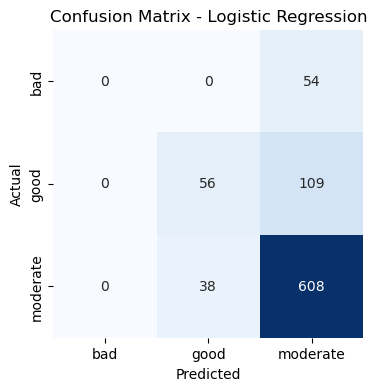

c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

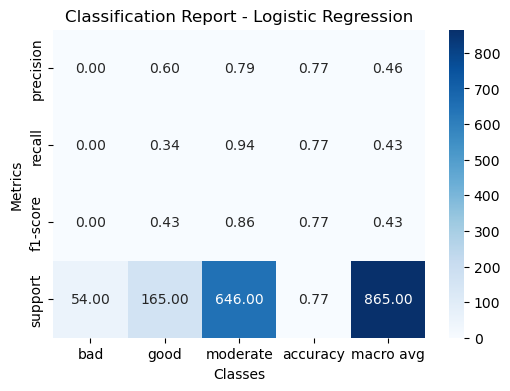

In [18]:
clf_lg = LogisticRegression(max_iter=1000, random_state=42)
clf_lg.fit(X_train, y_train)
lg_valid_accuracy = evaluate_model(clf_lg, X_valid, y_valid, 'Logistic Regression', 'Validation')

### Model 2: Random Forest Classifier
Random Forest is an ensemble method that builds multiple decision trees during traning process and averages their outputs. t uses bootstrapping (random sampling with replacement) and feature randomness to create diverse trees, which helps in reducing overfitting.

Hyperparameters Used: `random_state=42` (ensures reproducibility).


--- Random Forest ---
Validation Accuracy: 0.7746


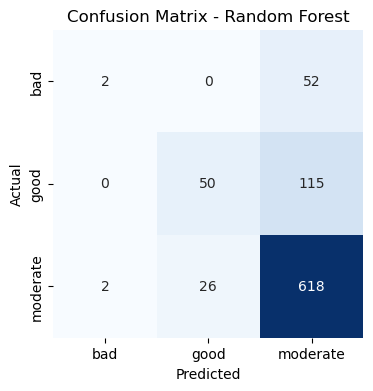

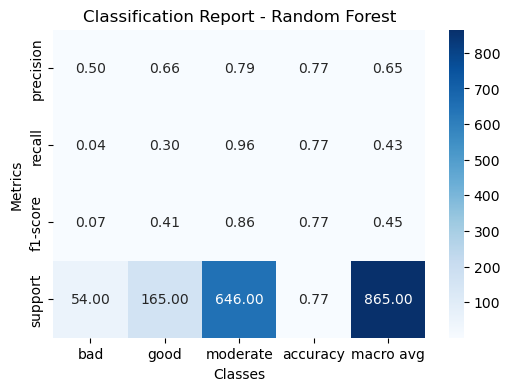

In [19]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_valid_accuracy = evaluate_model(clf_rf, X_valid, y_valid, 'Random Forest', 'Validation')

### Model 3: Support Vector Machine Classifier
Support Vector Machine (SVM) is a powerful classifier that works by finding the hyperplane that best separates data points of different classes. It maximizes the margin between the closest points (support vectors) of the classes. 

Hyperparameters Used: `random_state=42` (ensures reproducibility).


--- SVM ---
Validation Accuracy: 0.7468


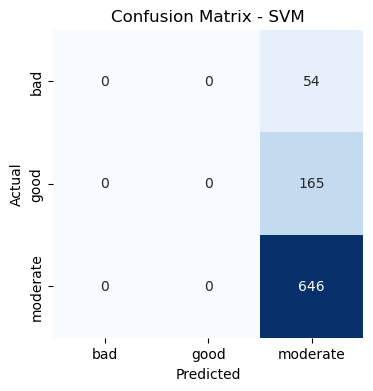

c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

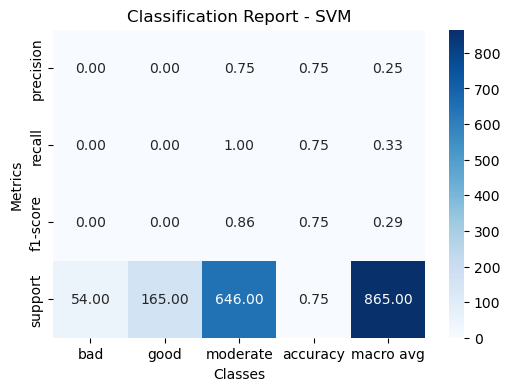

In [20]:
clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train, y_train)
svm_valid_accuracy = evaluate_model(clf_svm, X_valid, y_valid, 'SVM', 'Validation')

* Logistic Regression (74,68%): This model has the lowest accuracy. It’s a simple model that might not capture the complexity of the data well, especially if the relationships between features and the target are non-linear.
* Random Forest (76,99%): This model performs the best. Random Forest works well with complex data by combining multiple decision trees, making it better at handling non-linear patterns and reducing overfitting.
* Support Vector Machine (74,68%): SVM has a similar performance to Logistic Regression, but it may struggle with large or complex datasets without proper tuning.

=> Random Forest is the strongest performer here. However, due to the moderate accuracy, we have to try more to upgrage our model.

### Use SMOTE (Synthetic Minority Oversampling Technique) to balance samples

Use Borderline SMOTE, focus on generating synthetic samples near the decision boundary

In [21]:
print(f"Original class distribution:")
print(y_train.value_counts())

smote = BorderlineSMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check distribution of classes
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Original class distribution:
moderate    1979
good         486
bad          130
Name: quality, dtype: int64
Class distribution after SMOTE:
good        1979
moderate    1979
bad         1979
Name: quality, dtype: int64


Now try to aply to Random Forest


--- Random Forest (SMOTE) ---
Validation Accuracy: 0.7202


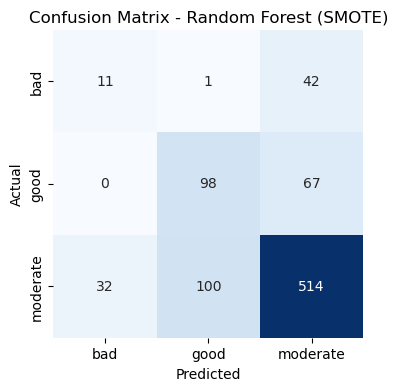

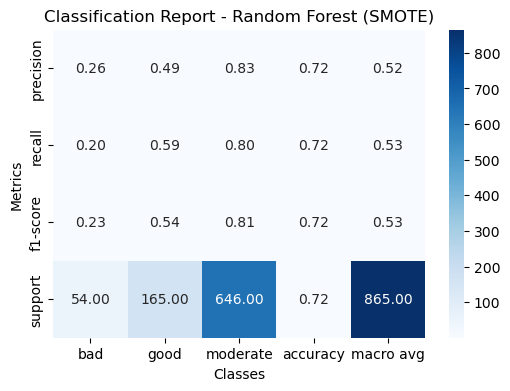

In [22]:
clf_rf2 = RandomForestClassifier(random_state=42)
clf_rf2.fit(X_train_smote, y_train_smote)

# Validate
rf2_valid_accuracy = evaluate_model(clf_rf2, X_valid, y_valid, 'Random Forest (SMOTE)', 'Validation')

Oops, the validation now decrease a much, it seems like simply balancing the data is not a good choice to enhance the model's performance.

### Feature selection

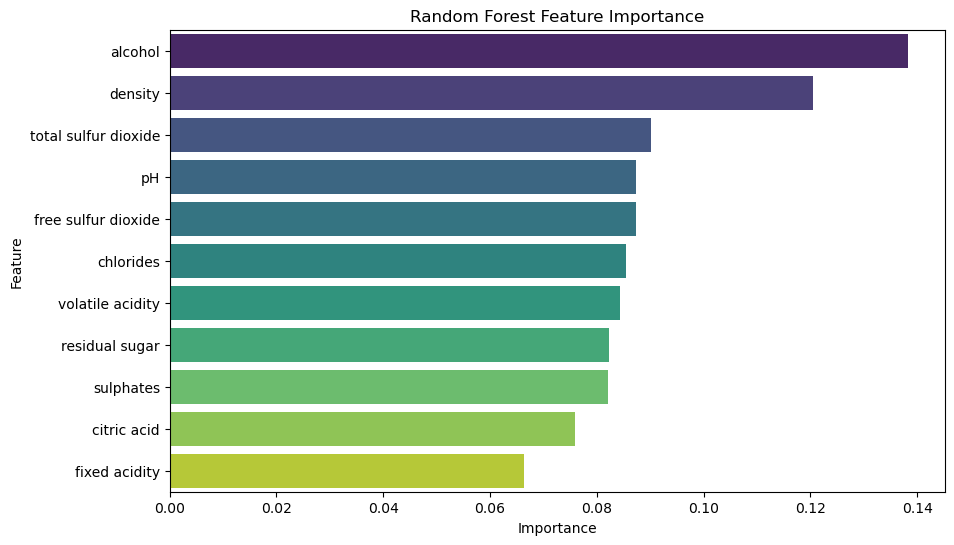

In [23]:
if hasattr(clf_rf, 'feature_importances_'):
    importances = clf_rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Random Forest Feature Importance')
    plt.show()

Among all the features, alcohol stands out as the most influential, indicating its strong relationship with the target variable. Following this, density and volatile acidity also show significant importance, suggesting their substantial roles in the model. 

Consider removing or transforming low-importance features, such as sulphates, pH, citric acid, fixed acidity, to simplify the model if they do not improve predictive performance.


--- Random Forest with Feature Dropping ---
Validation Accuracy: 0.7711


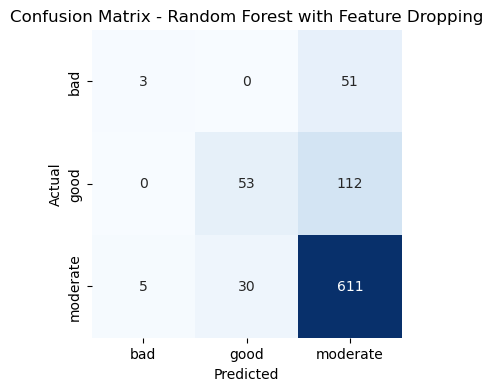

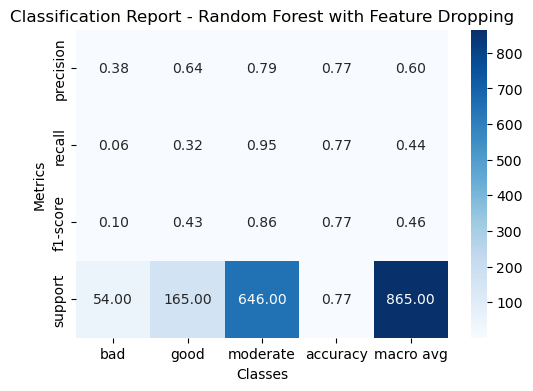

In [29]:
X_train2 = X_train.copy()
X_train2.drop(columns=['sulphates', 'pH', 'citric acid', 'fixed acidity'], inplace=True)

X_valid2 = X_valid.copy()
X_valid2.drop(columns=['sulphates', 'pH', 'citric acid', 'fixed acidity'], inplace=True)

X_test2 = X_test.copy()
X_test2.drop(columns=['sulphates', 'pH', 'citric acid', 'fixed acidity'], inplace=True)

clf_rf3 = RandomForestClassifier(random_state=42)
clf_rf3.fit(X_train2, y_train)
rf3_valid_accuracy = evaluate_model(clf_rf3, X_valid2, y_valid, 'Random Forest with Feature Dropping', 'Validation')


With the feature selection, our model is slightly imroved with 77,1% of validation accuracy. It's a good signal for us. Let's try something else...

### Hyperparameter Tuning

Use grid search or random search to find the optimal hyperparameters for our models.


--- Random Forest with Grid Search ---
Validation Accuracy: 0.7676


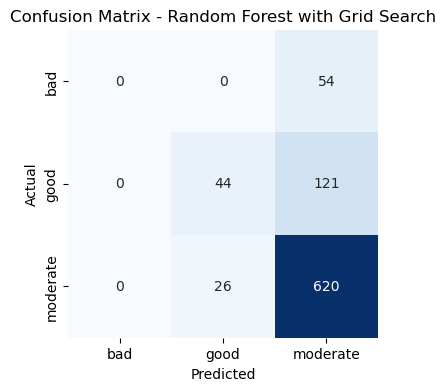

c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\LENOVO\miniconda3\envs\min_ds-env2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

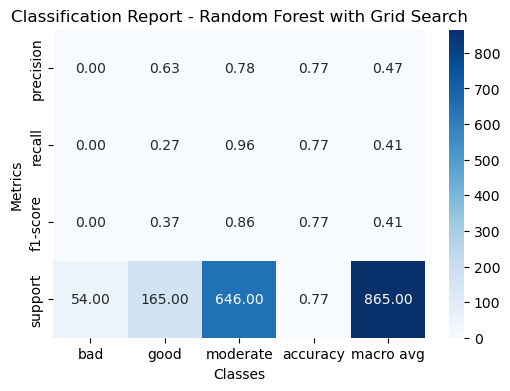

Random Forest Validation Accuracy with Hyperparameter Tuning: 0.7710982658959538


In [25]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model
best_rf = grid_search.best_estimator_
rf4_valid_accuracy = evaluate_model(best_rf, X_valid, y_valid, 'Random Forest with Grid Search', 'Validation') 

print("Random Forest Validation Accuracy with Hyperparameter Tuning:", rf3_valid_accuracy)

### Model Evaluation on Test Set


--- Random Forest ---
Test Accuracy: 0.7988


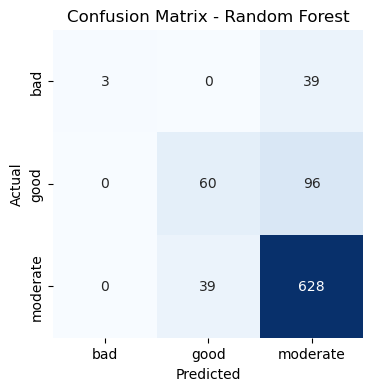

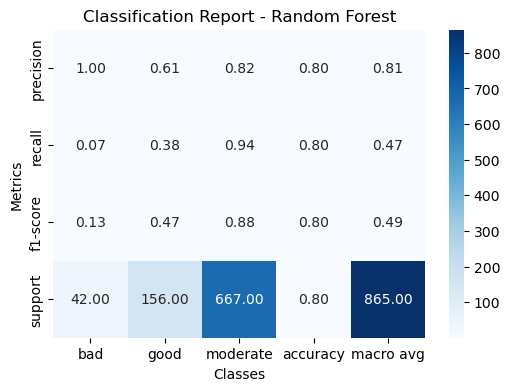

In [30]:
rf3_test_accuracy = evaluate_model(clf_rf, X_test, y_test, "Random Forest")                  

## Conclusion

**The best method is: Random Forest with top 8 features**

Despite my best efforts to enhance the performance of the wine quality prediction model and achieve optimal results, I was unable to attain my desired output. The validation accuracy keep at most 76,99% at normal Random Forest model with test accuracy still remains at a modest 80%. 

A possible reason for this could be the inherent complexity and variability of the wine quality dataset, which might require more advanced feature engineering or additional data preprocessing to capture the underlying patterns more effectively. 